# Regressione Predict Podcast Listening Time

Progetto di programmazione di applicazioni data intensive a.a. 2024/2025 \
Realizzato da: Senni Mattia

Questo elaborato è basato su una competizione di kaggle [visualizzabile qui](https://www.kaggle.com/competitions/playground-series-s5e4/data?select=test.csv) \
Tutti i dataset sia train che test sono entrambi disponibili al link della competizione. 

## Istruzioni per il download del dataset
il Dataset va inserito all'interno della cartella /dataset. 
Il dataset è composto di 2 file test.csv e train.csv i rispettivi dataset di test e train.
Per procedere al download del dataset è necessario possedere un account Kaggle, generare un API key dalle impostazioni di kaggle e configurare il pacchetto python kaggle per il corretto funzionamento in locale.
Una volta configurato kaggle correttamente sarà sufficiente eseguire i seguente comandi all'interno della cartella `/dataset`: \
`kaggle competitions download -c playground-series-s5e4` e `unzip playground-series-s5e4.zip`

# Fase 1: Progetto e dataset
Questo progetto vuole dare una soluzione ad una challenge pubblicata su kaggle: Predict podcast listening time, il cui obbiettivo è quello di, dati diversi dati del podcast, predirre il tempo di ascolto in minuti del relativo podcast. \
Il dataset è reperibile alla pagina della competizione [link](https://www.kaggle.com/competitions/playground-series-s5e4/data?select=test.csv)

Inizio spigando le librerie che verranno utilizzate nella fase 1:
- Pandas: libreria utilizzata per la gestione di dati in forma tabulare
- Matplotlib: libreria utilizzata per la creazione di grafici

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

Inizio subito cancellando la colonna Id inutile ai nostri fini in quanto non riporta alcuna relazione con la colonna `Listening_Time_minutes`.

In [33]:
df_train = pd.read_csv("dataset/train.csv")
df_train = df_train.drop(columns=["id"])
df_train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


Descrizione del dataset:
- Podcast_name: stringa, il nome del podcast
- Episode_Title: stringa, il nome dell'episodio Episode \<episode-id\>
- Episode_Length_minutes: float, La lunghezza dell'episodio in minuti
- Genre: stringa, Il genere dell'episodio
- Host_Popularity_Percentage: float, la popolarità del podcast
- Publication_Day: stringa, il giorno della settimana della pubblicazione del podcast
- Publication_Time: stringa, il momento della giornata della pubblicazione del podcast
- Guest_Popularity_percentage: float, la popolarità del guest
- Number_of_Ads: intero, Il numero di Ads durante l'ascolto
- Episode_Sentiment: stringa, il livello di approvazione della gente per quel podcast
- Listening_Time_minutes: int, variabile target, il tempo di ascolto del podcast

Procediamo visualizzando la distribuzione dei valori nulli nel dataset

In [34]:
from pandas import DataFrame
def print_missing_value_plot(df: DataFrame):
    df.isnull().sum().plot(kind='bar', title="Numero di elementi nulli nelle colonne del dataset")
    plt.figure(figsize=(12,6))
    plt.show()
    print(f"Numero di righe: {len(df)}")
    for col in df.columns:
        print(f"Colonna {col}, valori nulli: {df[col].isnull().sum()}")

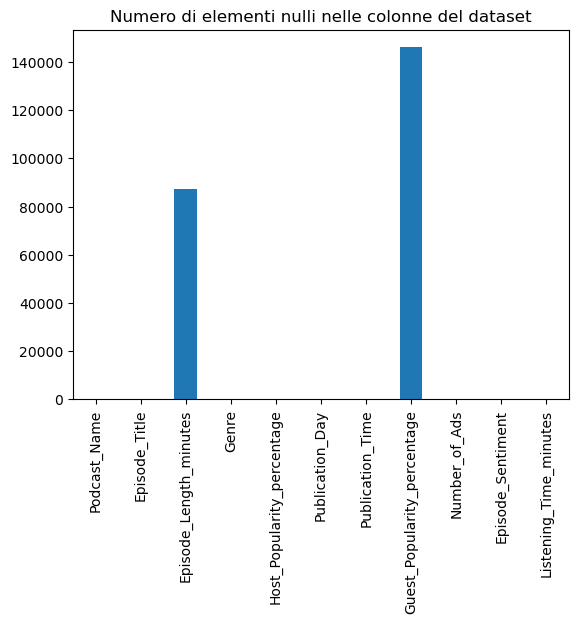

<Figure size 1200x600 with 0 Axes>

Numero di righe: 750000
Colonna Podcast_Name, valori nulli: 0
Colonna Episode_Title, valori nulli: 0
Colonna Episode_Length_minutes, valori nulli: 87093
Colonna Genre, valori nulli: 0
Colonna Host_Popularity_percentage, valori nulli: 0
Colonna Publication_Day, valori nulli: 0
Colonna Publication_Time, valori nulli: 0
Colonna Guest_Popularity_percentage, valori nulli: 146030
Colonna Number_of_Ads, valori nulli: 1
Colonna Episode_Sentiment, valori nulli: 0
Colonna Listening_Time_minutes, valori nulli: 0


In [35]:
print_missing_value_plot(df_train)

Dal grafico possiamo vedere che i valori nulli sono nelle colonne Episode_Length_minutes (dove mancano 80000 valori su 750000 righe), Guest_Popularity_percentage (dove mancano 140000 valori su 750000 righe) e Number_od_Ads (dove manca 1 valore su 750000 righe).
- Per gestire Episode_Length_minutes verrà scelto di eliminare le righe a cui manca questo valore, essendo che il data è sintetico si ipotizza che questi valori possano danneggiare le performance del modello (dal grafico sottostante possiamo infatti vedere che i valori mancanti sono valori di con `Listening_Time_minutes` distribuito su tutto il dataset una loro supposizione per termine mediano o per assegnamento di un valore uniforme ad ogni riga porterebbe alla creazione di rumore nella dipendenza lineare tra Episode_Length_minutes e Listening_Time_minutes ).
- Per gestire Guest_Popularity_percentage verrà messo il valore 0 alle righe mancanti aggiungendo poi un campo Guest_Popularity_missing con valore a 1 se Guest_Popularity_percentage è null, 0 altrimenti, assumendo che se manca il valore è perchè non è presente un ospite
- Per gestire Number_od_Ads verrà messo un valore di default a 0 assumendo che non ci siano state ads in quell'ascolto

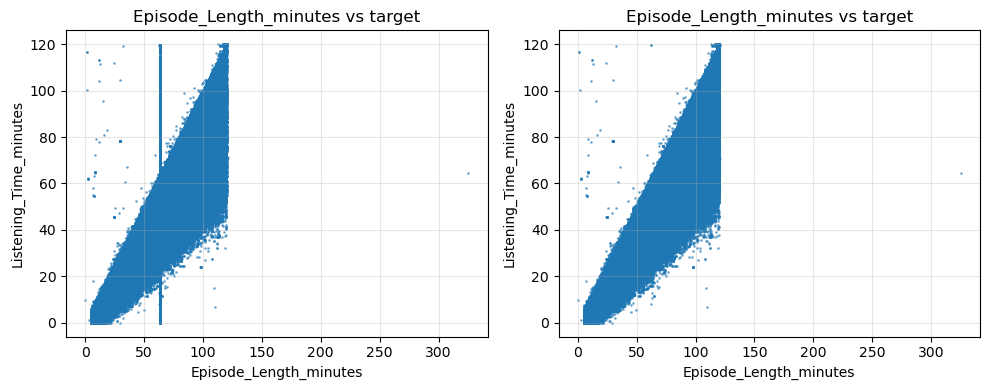

In [36]:
df_temp = df_train.copy()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.ravel()
target = "Listening_Time_minutes"

df_temp['Episode_Length_minutes'] = df_temp['Episode_Length_minutes'].fillna(df_temp['Episode_Length_minutes'].median())
axes[0].scatter(df_temp['Episode_Length_minutes'], df_temp['Listening_Time_minutes'], alpha=0.5, s=1)
axes[0].set_xlabel('Episode_Length_minutes')
axes[0].set_ylabel('Listening_Time_minutes')
axes[0].set_title('Episode_Length_minutes vs target')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(df_train['Episode_Length_minutes'], df_train['Listening_Time_minutes'], alpha=0.5, s=1)
axes[1].set_xlabel('Episode_Length_minutes')
axes[1].set_ylabel('Listening_Time_minutes')
axes[1].set_title('Episode_Length_minutes vs target')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Elimino anche il valore con episode length minute ~330 con listening time minute ~65 in quanto riga errata generata sinteticamente

In [37]:
df_train = df_train[(df_train['Episode_Length_minutes'] > 0) & (df_train['Episode_Length_minutes'] < 200)]

df_train['Guest_Popularity_missing'] = df_train['Guest_Popularity_percentage'].isna().astype(int)
df_train['Guest_Popularity_percentage'].fillna(0, inplace=True)

df_train["Number_of_Ads"].fillna(0, inplace=True)

## Fase 2: Analisi esplorativa

librerie:
- seaborn: libreria basata su matplotlib che aggiunge il supporto per ulteriori tipi di grafici

In [38]:
import seaborn as sns

Prima di procedere all'analisi esplorativa effettuo però un'operazione di pulizia dati, cancello tutte le righe che contengono valori non ammessi secondo i seguenti criteri
- Host_Popularity_percentage: valori da 0 a 100
- Guest_Popularity_percentage: valori da 0 a 100
- Number_of_Ads: valori da 0 a 3 ed interi
- Episode_Length_minutes: sempre minore di Listening_Time_minutes

\
Procediamo inoltre affidando ad ogni colonna il tipo di dato corretto

In [39]:
df_train['Podcast_Name'] = df_train['Podcast_Name'].astype('category')
df_train['Episode_Title'] = df_train['Episode_Title'].astype('category')
df_train['Episode_Length_minutes'] = pd.to_numeric(df_train['Episode_Length_minutes'], errors='coerce')
df_train['Genre'] = df_train['Genre'].astype('category')
df_train['Host_Popularity_percentage'] = pd.to_numeric(df_train['Host_Popularity_percentage'], errors='coerce')
df_train['Publication_Day'] = df_train['Publication_Day'].astype('category')
df_train['Publication_Time'] = df_train['Publication_Time'].astype('category')
df_train['Guest_Popularity_percentage'] = pd.to_numeric(df_train['Guest_Popularity_percentage'], errors='coerce')
df_train['Number_of_Ads'] = df_train['Number_of_Ads'].astype(int)
df_train['Episode_Sentiment'] = df_train['Episode_Sentiment'].astype('category')
df_train['Listening_Time_minutes'] = pd.to_numeric(df_train['Listening_Time_minutes'], errors='coerce')

df_train = df_train[
    (df_train['Host_Popularity_percentage'] >= 0) & (df_train['Host_Popularity_percentage'] <= 100) &
    (df_train['Guest_Popularity_percentage'] >= 0) & (df_train['Guest_Popularity_percentage'] <= 100) &
    (df_train['Number_of_Ads'].isin([0, 1, 2, 3])) &
    (df_train['Episode_Length_minutes'] >= df_train['Listening_Time_minutes'])
]

Inizio riportando la distribuzione dei valori all'interno delle varie colonne del dataset

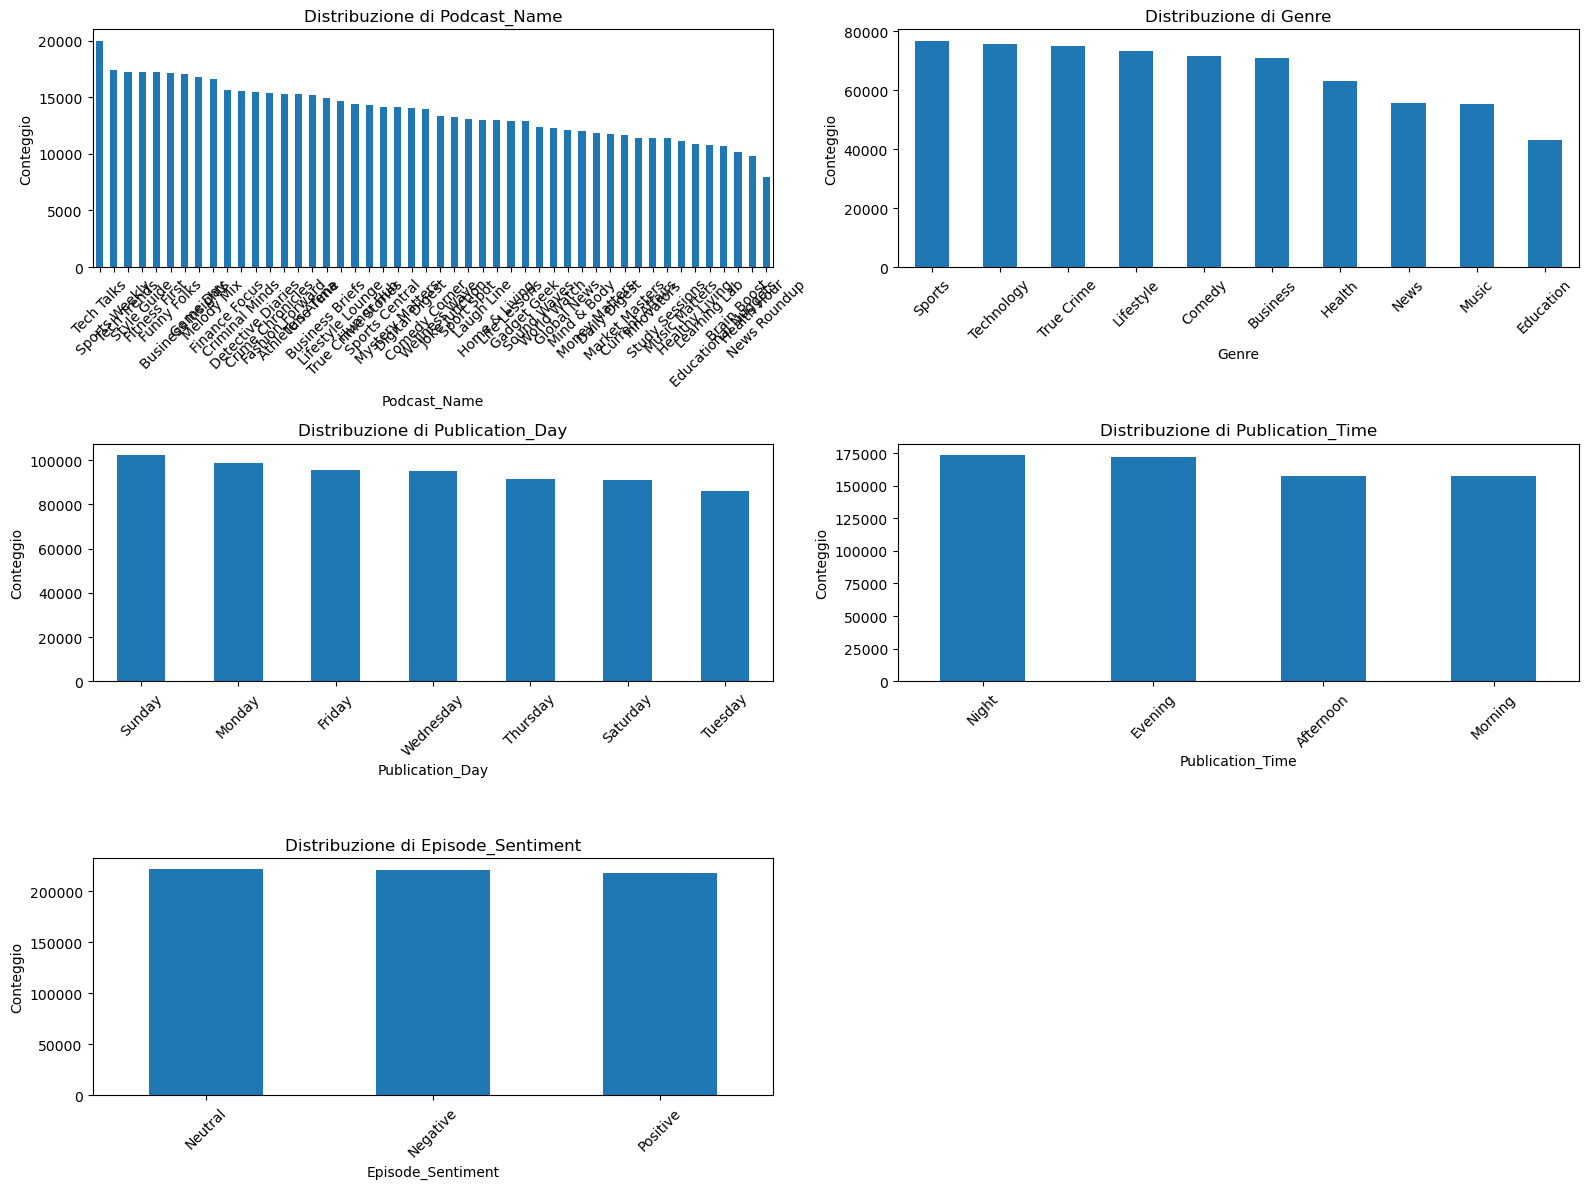

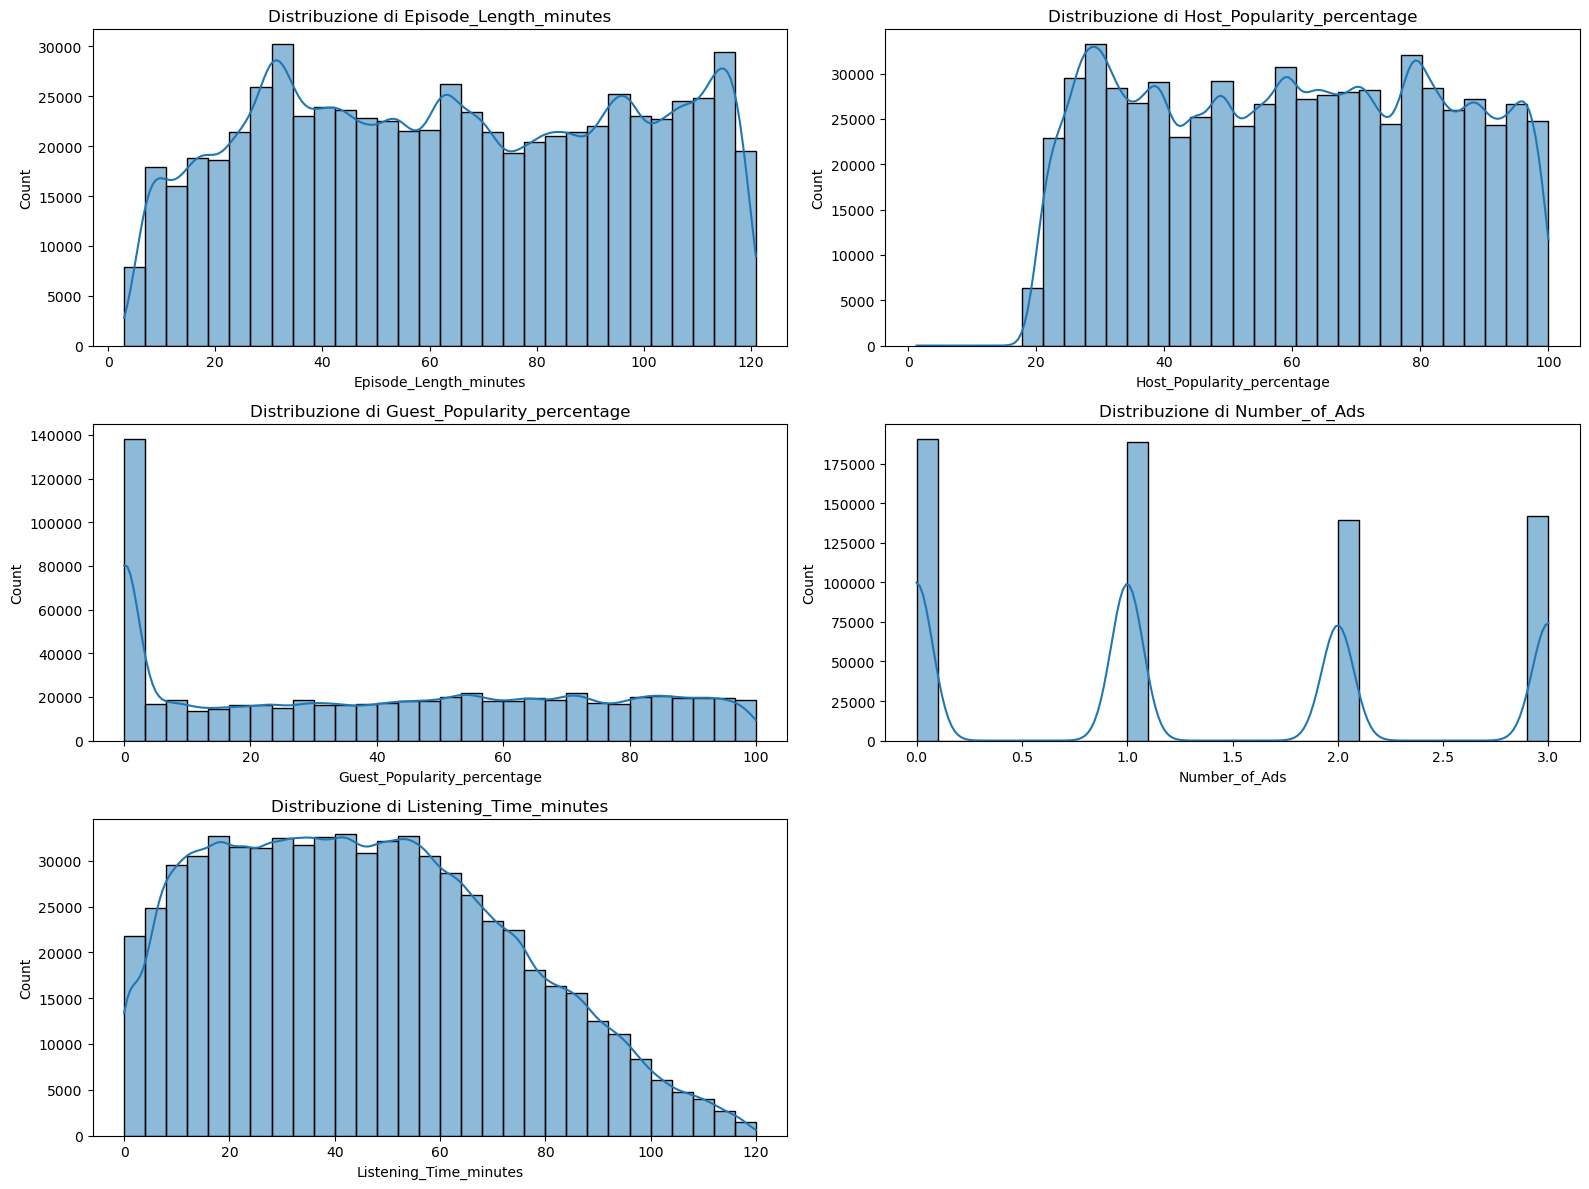

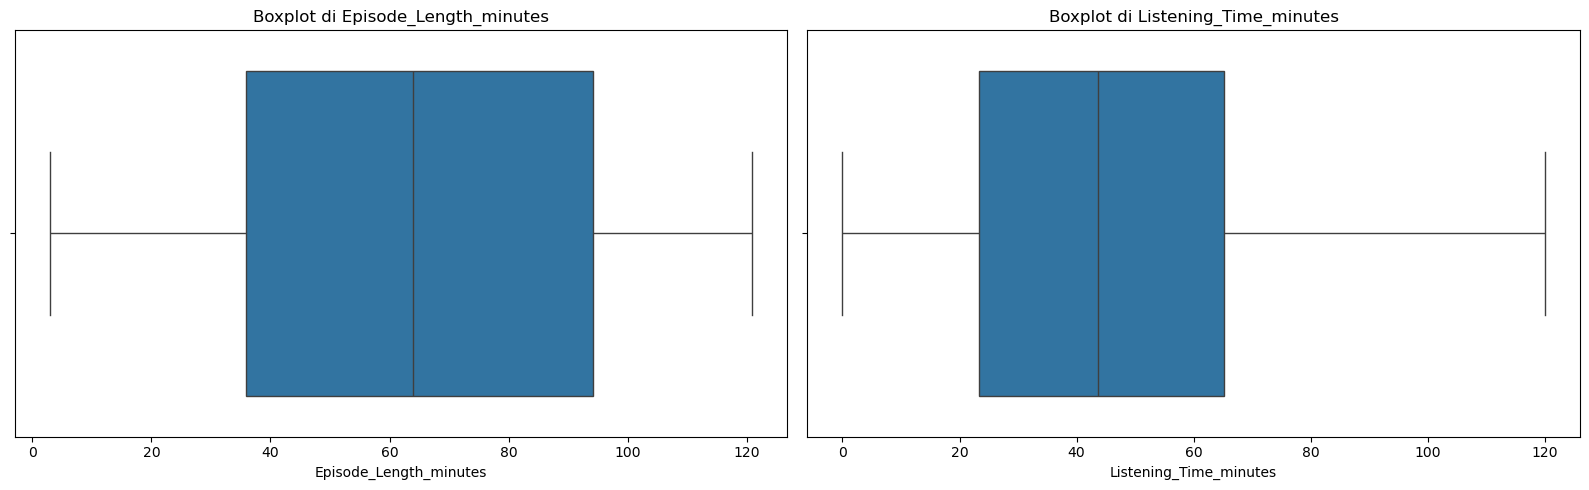

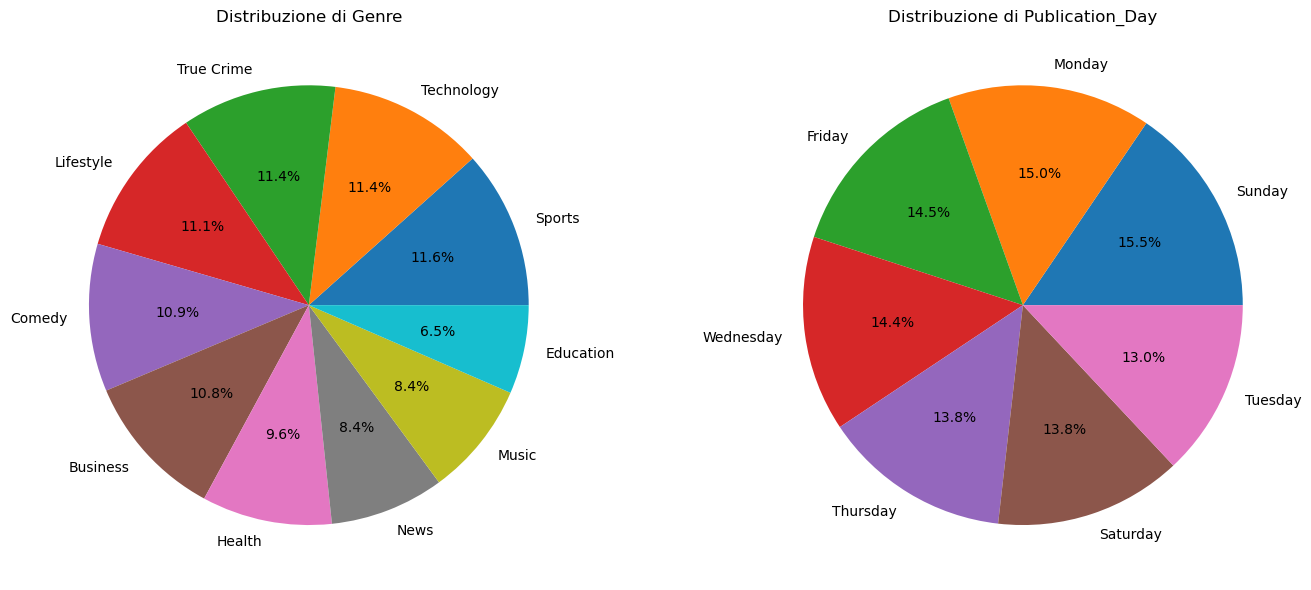

In [40]:
df = df_train.copy()

# Bar plot delle variabili categoriche
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
curr_plot = 0

ax = axes[0, 0]
df['Podcast_Name'].value_counts().plot(kind='bar', ax=ax)
ax.set_title("Distribuzione di Podcast_Name")
ax.set_ylabel("Conteggio")
ax.tick_params(axis='x', rotation=45)
curr_plot += 1

ax = axes[0, 1]
df['Genre'].value_counts().plot(kind='bar', ax=ax)
ax.set_title("Distribuzione di Genre")
ax.set_ylabel("Conteggio")
ax.tick_params(axis='x', rotation=45)
curr_plot += 1

ax = axes[1, 0]
df['Publication_Day'].value_counts().plot(kind='bar', ax=ax)
ax.set_title("Distribuzione di Publication_Day")
ax.set_ylabel("Conteggio")
ax.tick_params(axis='x', rotation=45)
curr_plot += 1

ax = axes[1, 1]
df['Publication_Time'].value_counts().plot(kind='bar', ax=ax)
ax.set_title("Distribuzione di Publication_Time")
ax.set_ylabel("Conteggio")
ax.tick_params(axis='x', rotation=45)
curr_plot += 1

ax = axes[2, 0]
df['Episode_Sentiment'].value_counts().plot(kind='bar', ax=ax)
ax.set_title("Distribuzione di Episode_Sentiment")
ax.set_ylabel("Conteggio")
ax.tick_params(axis='x', rotation=45)

axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Istogrammi delle variabili numeriche
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
curr_plot = 0

ax = axes[0, 0]
sns.histplot(df['Episode_Length_minutes'], kde=True, bins=30, ax=ax)
ax.set_title("Distribuzione di Episode_Length_minutes")
curr_plot += 1

ax = axes[0, 1]
sns.histplot(df['Host_Popularity_percentage'], kde=True, bins=30, ax=ax)
ax.set_title("Distribuzione di Host_Popularity_percentage")
curr_plot += 1

ax = axes[1, 0]
sns.histplot(df['Guest_Popularity_percentage'], kde=True, bins=30, ax=ax)
ax.set_title("Distribuzione di Guest_Popularity_percentage")
curr_plot += 1

ax = axes[1, 1]
sns.histplot(df['Number_of_Ads'], kde=True, bins=30, ax=ax)
ax.set_title("Distribuzione di Number_of_Ads")
curr_plot += 1

ax = axes[2, 0]
sns.histplot(df['Listening_Time_minutes'], kde=True, bins=30, ax=ax)
ax.set_title("Distribuzione di Listening_Time_minutes")

axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Boxplot
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

ax = axes[0]
sns.boxplot(data=df, x='Episode_Length_minutes', ax=ax)
ax.set_title("Boxplot di Episode_Length_minutes")

ax = axes[1]
sns.boxplot(data=df, x='Listening_Time_minutes', ax=ax)
ax.set_title("Boxplot di Listening_Time_minutes")

plt.tight_layout()
plt.show()

# Pie chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
df['Genre'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax)
ax.set_title("Distribuzione di Genre")
ax.set_ylabel("")

ax = axes[1]
df['Publication_Day'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax)
ax.set_title("Distribuzione di Publication_Day")
ax.set_ylabel("")
ax = axes[1]

plt.tight_layout()
plt.show()


Considerazioni: Le variabili categoriche sono ben distribuite così come il numero di ads. \
In generale i valori nel DB sono ben distribuiti 

Procediamo ad analizzare la distribuzione dei valori per il campo `Listening_Time_minutes` rispetto agli altri valori del dataset.

In [41]:
numerical_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 
                 'Guest_Popularity_percentage', 'Number_of_Ads']
categorical_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

Number_of_Ads means: Number_of_Ads
0    49.339046
1    47.766667
2    43.396263
3    40.401903
Name: Listening_Time_minutes, dtype: float64
Genre means: Genre
Business      45.591152
Comedy        44.728913
Education     45.951081
Health        46.006653
Lifestyle     45.851820
Music         46.826043
News          44.680192
Sports        45.071222
Technology    46.224794
True Crime    46.370039
Name: Listening_Time_minutes, dtype: float64
Publication_Day means: Publication_Day
Friday       45.464243
Monday       46.174665
Saturday     45.456213
Sunday       45.095195
Thursday     45.346649
Tuesday      46.502448
Wednesday    46.063986
Name: Listening_Time_minutes, dtype: float64
Publication_Time means: Publication_Time
Afternoon    45.901487
Evening      44.980586
Morning      45.207504
Night        46.740514
Name: Listening_Time_minutes, dtype: float64
Episode_Sentiment means: Episode_Sentiment
Negative    44.280940
Neutral     45.838612
Positive    47.050090
Name: Listening_Time_min

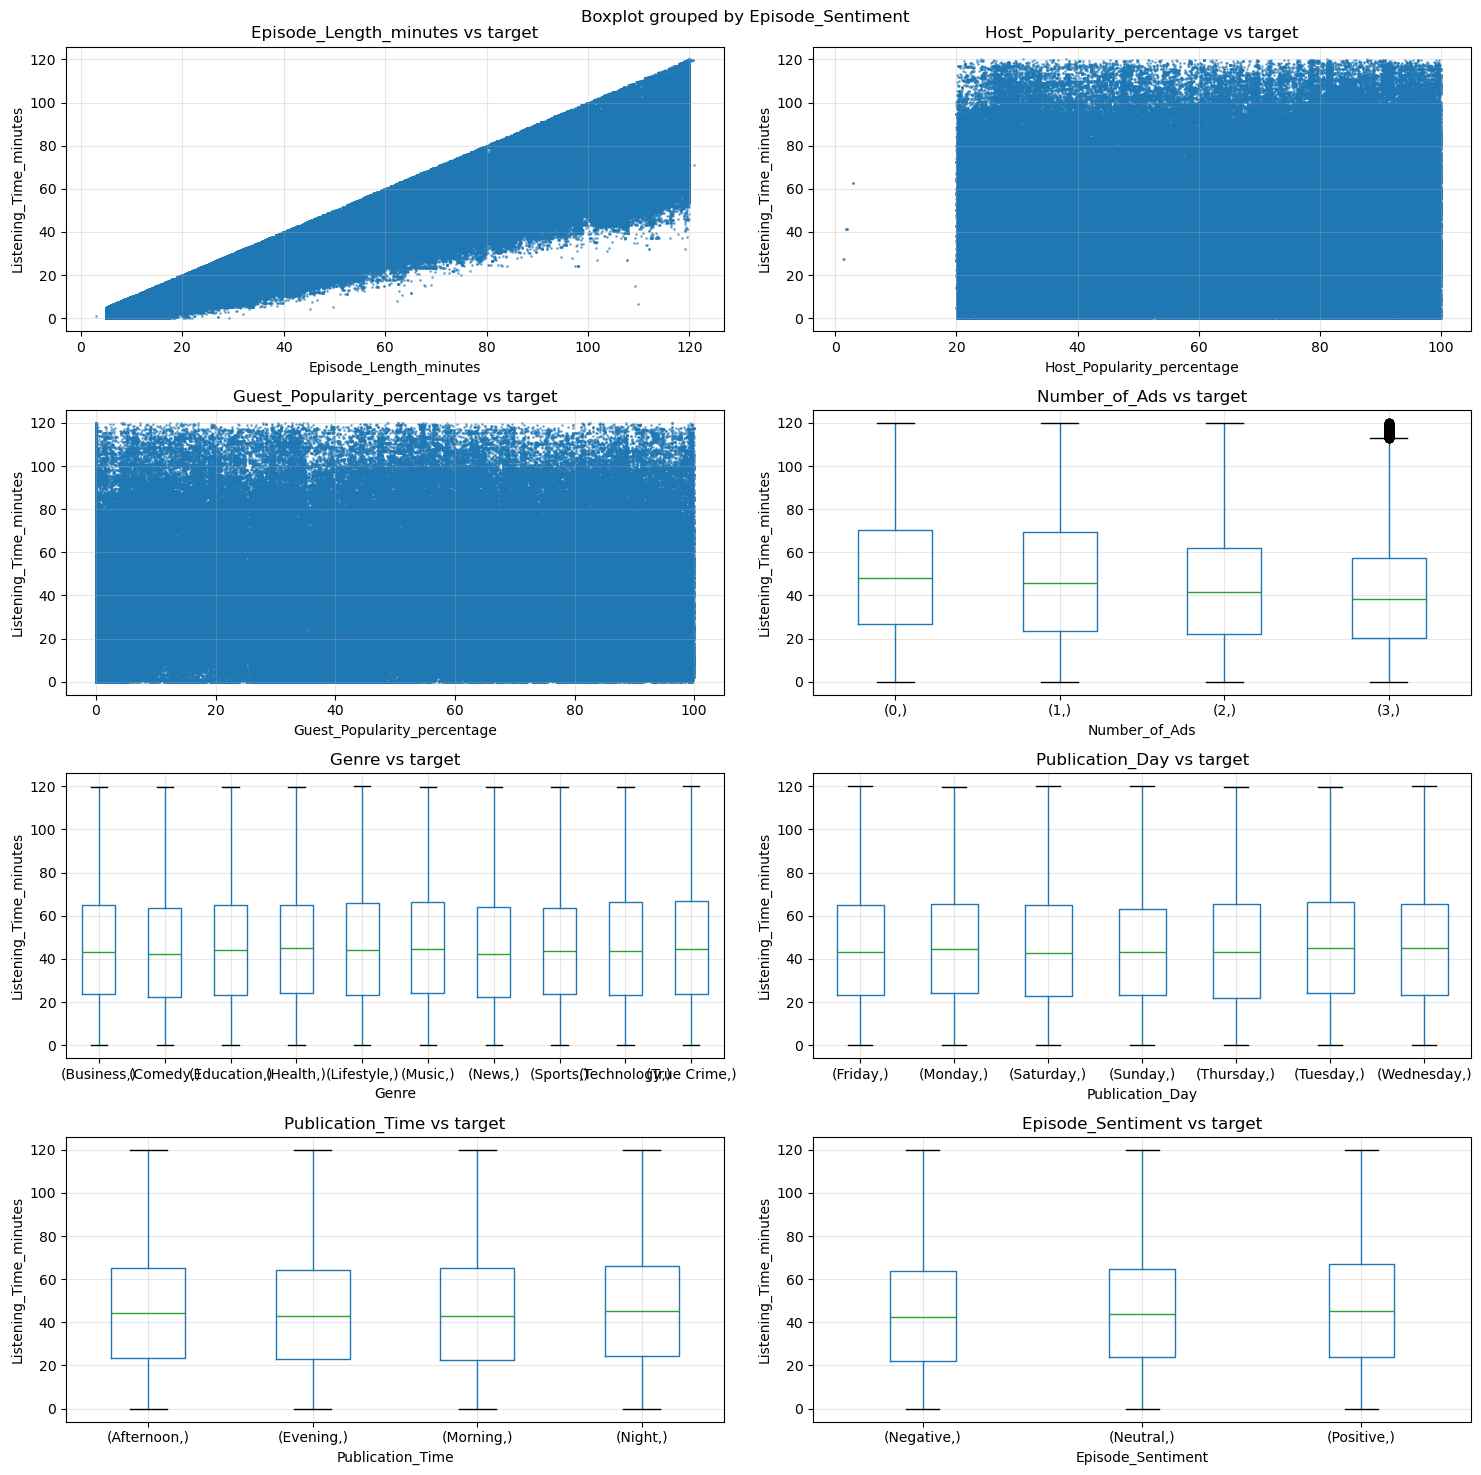

In [42]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
axes = axes.ravel()
target = "Listening_Time_minutes"

for i, col in enumerate(numerical_cols + categorical_cols):
    if col in df_train.columns:
        if col not in categorical_cols + ["Number_of_Ads"]:
            axes[i].scatter(df_train[col], df_train[target], alpha=0.5, s=1)
            axes[i].set_xlabel(col)
            axes[i].set_ylabel(target)
            axes[i].set_title(f'{col} vs target')
            axes[i].grid(True, alpha=0.3)
        else:
            df_train.boxplot(column=target, by=[col], ax=axes[i])
            axes[i].set_xlabel(col)
            axes[i].set_ylabel(target)
            axes[i].set_title(f'{col} vs target')
            axes[i].grid(True, alpha=0.3)
            print(f"{col} means: {df_train.groupby(col)[target].mean()}")
plt.tight_layout()
plt.show()

Andiamo ora ad analizzare la relazione tra il nome del podcast e tempo di ascolto in minuti, nei seguenti grafici (un box plot ed un bar plot) possiamo notare che ci sono alcuni podcast con tempo medio di ascolto maggiore di altri, per cui il nome del podcast potrebbe essere utile al nostro modello per predire correttamente il tempo di ascolto

Text(0.5, 1.0, 'media nome del podcast - Listenting Time mintues')

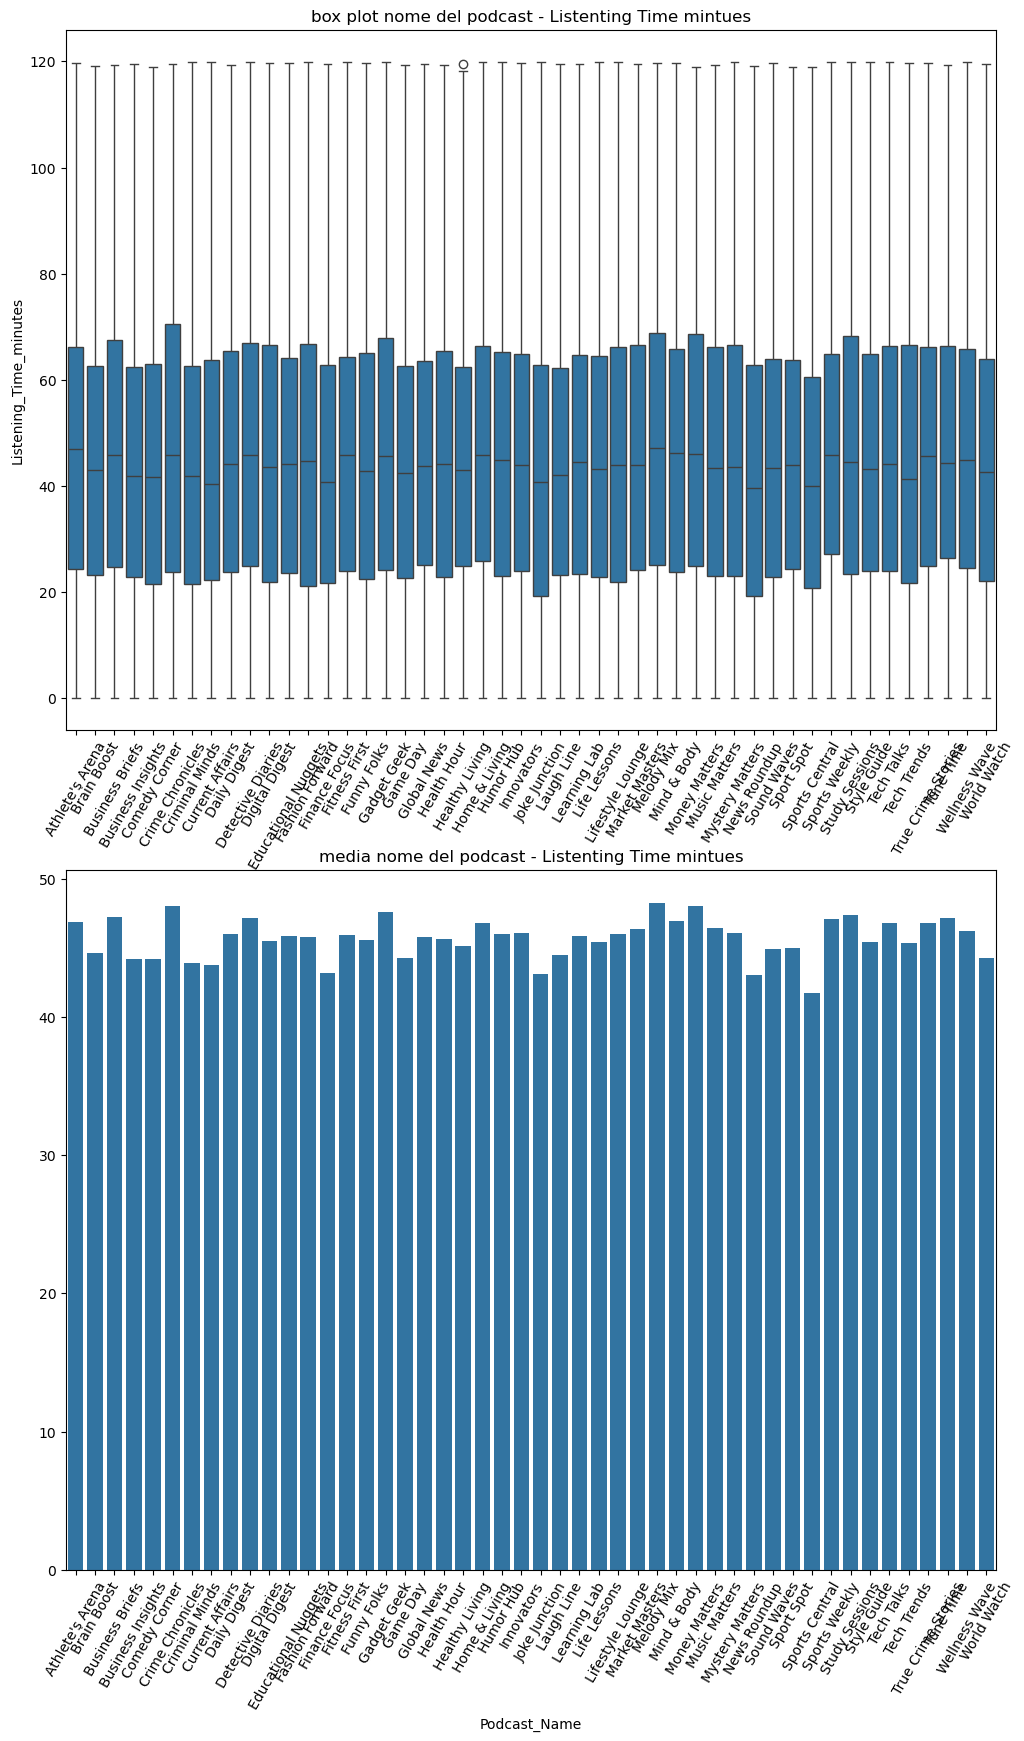

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(12, 20))
axes = axes.ravel()

sns.boxplot(data=df_train, x='Podcast_Name', y='Listening_Time_minutes', ax=axes[0])
axes[0].tick_params(axis='x', rotation=60)
axes[0].set_title("box plot nome del podcast - Listenting Time mintues")

podcast_means = df_train.groupby('Podcast_Name')['Listening_Time_minutes'].mean().sort_values(ascending=False)
sns.barplot(x=podcast_means.index, y=podcast_means.values, ax=axes[1])
axes[1].tick_params(axis='x', rotation=60)
axes[1].set_title("media nome del podcast - Listenting Time mintues")

Dai grafici precedenti possiamo notare che c'è una leggera correlazione tra il nome del podcast ed il tempo di ascolto medio.

Procediamo quindi a visualizzare la matrice di correlazione tra le colonne numeriche per cercare relazioni tra le diverse feature

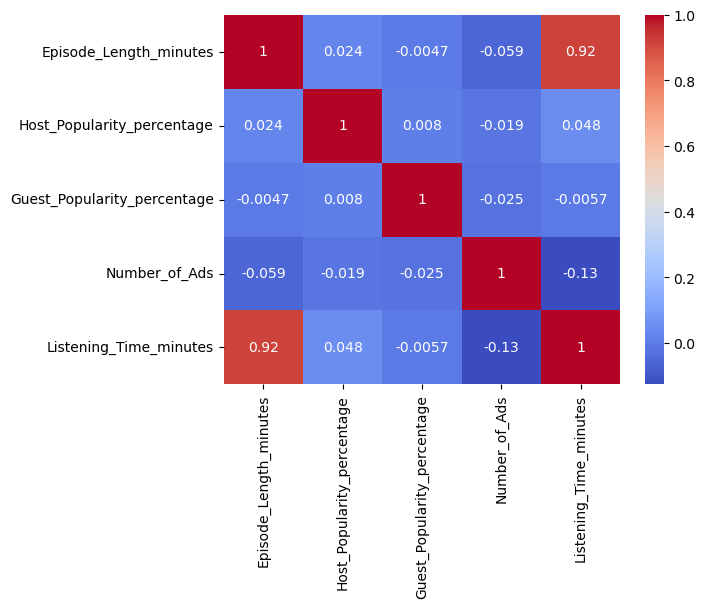

In [44]:
numeric_cols = numerical_cols + ["Listening_Time_minutes"]
corr = df_train[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

La matrice di correlazione mostra una relazione molto forte tra la durata di un episodio ed il tempo di ascolto, ed una piccola relazione tra il tempo di ascolto ed il numero di Ads  

## Fase 3: Preparazione dati
In questa fase, dopo una prima esplorazione del dataset verranno elaborati correttamente i dati del dataset e create o cancellate opportunamente le colonne per provare a migliorare le prestazioni del modello

Librerie:
- sklearn
    - Pipeline: Strumento utilizzato per creare delle pipeline in scikit-learn
    - OneHotEncoder: Encoder che trasforma una variabile categorica in una matrice binaria dove ogni categoria diventa una feature
    - StandardScaler: standardizza le feature numeriche portandole ad avere media = 0, deviazione standard = 1
    - PolynomialFeatures: genera nuove feature espandendo quelle esistenti in combinazione polinomiali
    - train_test_split: utility per creare train e validation set
    - ColumnTransformer: permette di applicare pipeline differenti in base alla colonna

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

Nel prossimo step procederemo a gestire i campi testuali semplici ovvero quelli con valori predefiniti. I valori predefiniti sono:
- Publication_Day: 'Thursday' 'Saturday' 'Tuesday' 'Monday' 'Sunday' 'Wednesday' 'Friday'
- Publication_Time: 'Night' 'Afternoon' 'Evening' 'Morning'
- Episode_Sentiment: 'Positive' 'Negative' 'Neutral'
- Genre: 'True Crime' 'Comedy' 'Education' 'Technology' 'Health' 'News' 'Music' 'Sports' 'Business' 'Lifestyle'

Per gestirli mapperemo i relativo valori in numeri interi

In [46]:
def print_unique_name(df, column_name):
    print(df[column_name].unique())
print_unique_name(df_train, "Publication_Day")
print_unique_name(df_train, "Publication_Time")
print_unique_name(df_train, "Episode_Sentiment")

['Saturday', 'Tuesday', 'Monday', 'Sunday', 'Thursday', 'Wednesday', 'Friday']
Categories (7, object): ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
['Afternoon', 'Evening', 'Morning', 'Night']
Categories (4, object): ['Afternoon', 'Evening', 'Morning', 'Night']
['Negative', 'Positive', 'Neutral']
Categories (3, object): ['Negative', 'Neutral', 'Positive']


In [47]:
day_order = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
                               'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df_train['Publication_Day_Numeric'] = df_train['Publication_Day'].map(day_order).fillna(0)

time_order = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}
df_train['Publication_Time_Numeric'] = df_train['Publication_Time'].map(time_order).fillna(0)

sentiment_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df_train['Episode_Sentiment_Numeric'] = df_train['Episode_Sentiment'].map(sentiment_map).fillna(0)

print_unique_name(df_train, "Publication_Day_Numeric")
print_unique_name(df_train, "Publication_Time_Numeric")
print_unique_name(df_train, "Episode_Sentiment_Numeric")

[5, 1, 0, 6, 3, 2, 4]
Categories (7, int64): [4, 0, 5, 6, 3, 1, 2]
[1, 2, 0, 3]
Categories (4, int64): [1, 2, 0, 3]
[0, 2, 1]
Categories (3, int64): [0, 1, 2]


Il prossimo step è cercare una correlazione tra il numero dell'episodio ed il listening time, per fare questo creiamo una nuova colonna Episode_Number che conterrà il solo numero intero dell'episodio estraendolo dal test

In [48]:
df_train['Episode_Number'] = df_train['Episode_Title'].str.extract(r'Episode (\d+)', expand=False).fillna(0)
df_train['Episode_Number'] = pd.to_numeric(df_train['Episode_Number'], errors='coerce').astype(int)
len(df_train[df_train['Episode_Number'].isna()])

0

In [49]:
df_train['Episode_Number'].head()

1    26
2    16
3    45
4    86
5    19
Name: Episode_Number, dtype: int64

A questo punto possiamo visualizzare una heatmap del tempo medio di ascolto per ogni episodio di ogni podcast che può aiutare ad identificare i pattern come ad esempio se all'aumentare dell'episodio aumenta il tempo di ascolto  

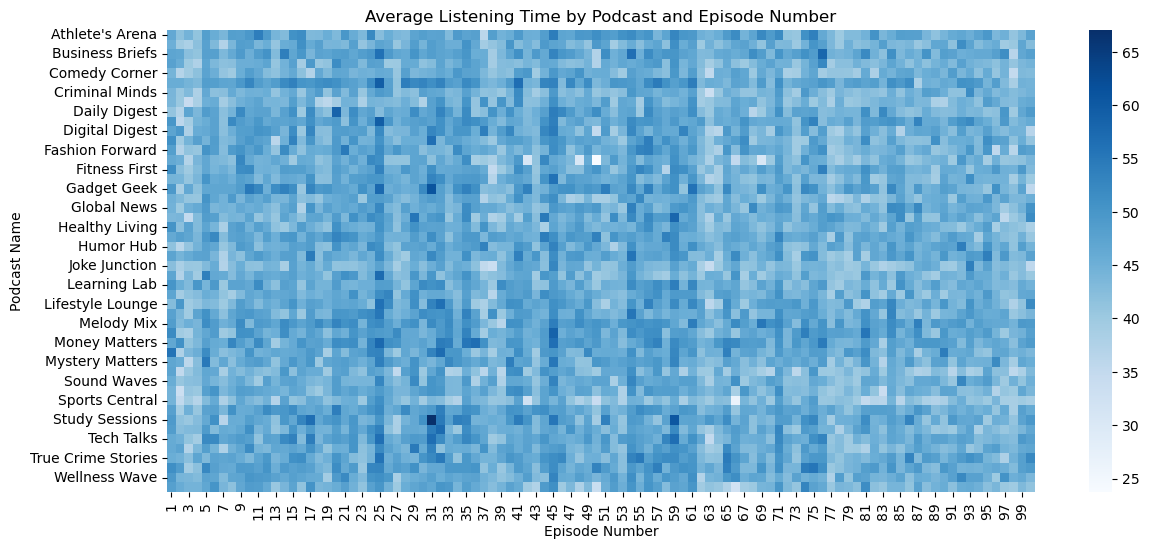

In [50]:
pivot = df_train.pivot_table(index='Podcast_Name', columns='Episode_Number', values='Listening_Time_minutes', aggfunc='mean')
plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap="Blues")
plt.title('Average Listening Time by Podcast and Episode Number')
plt.xlabel('Episode Number')
plt.ylabel('Podcast Name')
plt.show()

Dal grafico precedente possiamo dedurre che non ci sia una correlazione tra il numero di episodio ed il tempo di ascolto del podcast

A questo punto possiamo provare ad aggiungere feature al modello che possano essere utili per migliorare le prestazione del modello

In [51]:
df_train['Ads_per_minute'] = df_train['Number_of_Ads'] / (1 + df_train['Episode_Length_minutes'])
df_train['Has_Ads'] = (df_train['Number_of_Ads'] > 0).astype(int)

df_train['Is_Weekend'] = df_train['Publication_Day_Numeric'].isin([5, 6]).astype(int)

df_train['Medium_Episode_Length'] = ((df_train['Episode_Length_minutes'] > 60) & (df_train['Episode_Length_minutes'] <= 90)).astype(int)
df_train['Hight_Episode_Length'] = (df_train['Episode_Length_minutes'] > 90).astype(int)

df_train['Hight_Host_Popularity'] = (df_train['Host_Popularity_percentage'] > 80).astype(int)

df_train['Hight_Guest_Popularity'] = (df_train['Guest_Popularity_percentage'] > 80).astype(int)

df_train["Guest_Host_Combined_Popularity"] = (df_train["Guest_Popularity_percentage"] + df_train["Host_Popularity_percentage"]) / 2

In [52]:
df_train = df_train.drop(columns=["Publication_Day","Publication_Time","Episode_Sentiment", "Episode_Title"])
df_train.head()

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Guest_Popularity_missing,Publication_Day_Numeric,Publication_Time_Numeric,Episode_Sentiment_Numeric,Episode_Number,Ads_per_minute,Has_Ads,Is_Weekend,Medium_Episode_Length,Hight_Episode_Length,Hight_Host_Popularity,Hight_Guest_Popularity,Guest_Host_Combined_Popularity
1,Joke Junction,119.80,Comedy,66.95,75.95,2,88.01241,0,5,1,0,26,0.016556,1,1,0,1,0,0,71.450
2,Study Sessions,73.90,Education,69.97,8.97,0,44.92531,0,1,2,0,16,0.000000,0,0,1,0,0,0,39.470
3,Digital Digest,67.17,Technology,57.22,78.70,2,46.27824,0,0,0,2,45,0.029338,1,0,1,0,0,0,67.960
4,Mind & Body,110.51,Health,80.07,58.68,3,75.61031,0,0,1,1,86,0.026903,1,0,0,1,1,0,69.375
5,Fitness First,26.54,Health,48.96,0.00,3,22.77047,1,5,1,2,19,0.108932,1,1,0,0,0,0,24.480


A questo punto possiamo rianalizzare la matrice di correlazione con anche le nuove feature numeriche

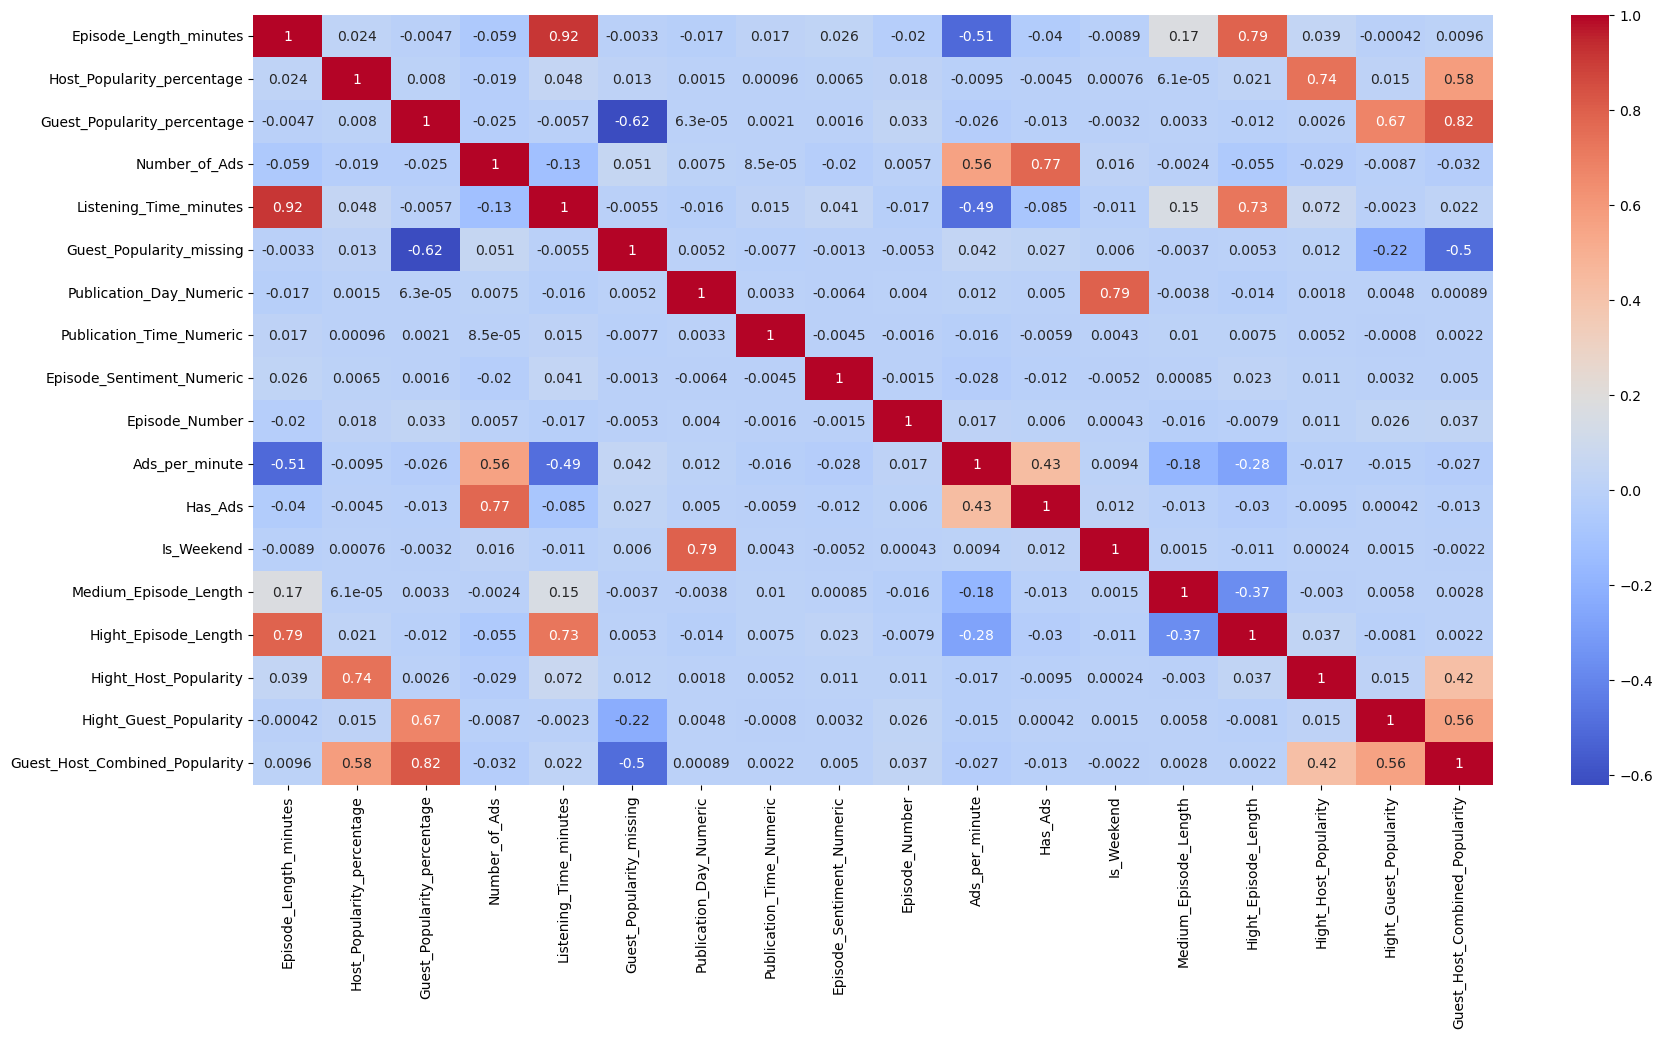

In [53]:
plt.figure(figsize=(20,10))
corr = df_train[df_train.columns.drop(["Podcast_Name", "Genre"])].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Il prossimo step è quello di definire le pipeline per i valori numerici e canonici
- valori numerici: utilizzo StandardScaler per standardizzare le feature numeriche, questo processo non è utile per modelli basati su alberi ma lo inserisco nella pipeline per avere una pipeline comune per tutti i modelli che si vogliono comparare
- valori canonici: utilizzo OneHotEncoder per convertire i valori canonici in matrici binarie per cui ogni categoria è una feature binaria

In [54]:
categorical_values = ['Podcast_Name', 'Genre']
target = 'Listening_Time_minutes'
numerical_values = df_train.columns.drop(categorical_values + [target]).to_list()


# Prepare the data
X = df_train[df_train.columns.drop(target)]
y = df_train[target]

numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

linear_model_numerical_transformer = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_values),
    ('cat', categorical_transformer, categorical_values)
])

linear_preprocessor = ColumnTransformer([
    ('num', linear_model_numerical_transformer, numerical_values),
    ('cat', categorical_transformer, categorical_values)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Fase 4: Addestramento del modello

In questa fase andremo ad addestrare quattro modelli di regressione per cercare di soddisfare il task richiesto, i modelli sono i seguenti

Librerie:
- sklearn
    - mean_squared_error: implementazione della relativa metrica
    - r2_score: implementazione della relativa metrica
    - LinearRegression: implementazione del modello di regressione lineare
    - DecisionTreeRegressor: implementazione del modello decision tree utilizzato per la regressione
    - plot_tree: funzione per mostrare il grafico dell'albero di regressione
    - RandomForestRegressor: implementazione del modello random forest utilizzato per la regressione
- xgboost: libreria contenente l'implementazione di un modello basato su gradient boosting
    - XGBRegressor: modello di regressione basato su gradient boosting
- numpy: libreria per processare dati

In [55]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np

Verrà fatta una comparazione tra i seguenti modelli
- Linear regressor
- ElasticNet
- Decision Tree
- Random Forest
- XGBoost

In [56]:
models = {
    "Linear Regression": LinearRegression(),
    "ElasticNet Regression": ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42),
}

Definisco le funzioni per valutare il modello oltre alle metriche R quadro e mean squared error che sono già implementate in scikit-learn

In [57]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8)))

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

Procedo ad addestrare i 4 modelli ed a salvarmi per ogni modello le metriche ottenute sul validation set

In [58]:
from sklearn.preprocessing import PolynomialFeatures
results = {} 

trained_models = {}

for name, model in models.items():
    print(f"Modello: {name} ")

    pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', model)
    ])

    if name in ["Linear Regression", 'ElasticNet Regression']:
        pipe = Pipeline([
            ('preprocessing', linear_preprocessor),
            ('regressor', model)
        ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rel_err = relative_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    trained_models[name] = pipe
    
    results[name] = {
        "MSE": mse,
        "R²": r2,
        "RMSE": rmse,
        "Errore Relativo": rel_err,
        "Model": pipe.named_steps['regressor'],
    }

Modello: Linear Regression 
Modello: ElasticNet Regression 
Modello: Decision Tree 
Modello: Random Forest 
Modello: XGBoost 


In [59]:
print("METRICHE DI PERFORMANCE")
for name, metrics in results.items():
    print(f"\n{name}")
    print(f"MSE: {metrics['MSE']:.2f}")
    print(f"R²: {metrics['R²']:.4f}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"Errore relativo medio: {metrics['Errore Relativo']:.4f}")

METRICHE DI PERFORMANCE

Linear Regression
MSE: 109.49
R²: 0.8525
RMSE: 10.4636
Errore relativo medio: 3463915.1162

ElasticNet Regression
MSE: 132.95
R²: 0.8209
RMSE: 11.5303
Errore relativo medio: 12735497.0616

Decision Tree
MSE: 113.30
R²: 0.8474
RMSE: 10.6441
Errore relativo medio: 3824822.5458

Random Forest
MSE: 107.51
R²: 0.8552
RMSE: 10.3686
Errore relativo medio: 2871489.7113

XGBoost
MSE: 106.86
R²: 0.8561
RMSE: 10.3374
Errore relativo medio: 3031189.3344


Per il modello di regressione lineare mi stampo i relativi coefficienti

In [60]:
print("\nCOEFFICIENTI MODELLI LINEARI")
for model_name in ['Linear Regression', 'ElasticNet Regression']:
    print(f"\nmodello {model_name}")
    lin_model = results[model_name]['Model']
    feature_names = pipe.named_steps['preprocessing'].get_feature_names_out()
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': lin_model.coef_
    }).sort_values(by='Coefficient', key=np.abs, ascending=False)
    print(coef_df.head(10))


COEFFICIENTI MODELLI LINEARI

modello Linear Regression


ValueError: All arrays must be of the same length

Per il modello decision tree stampo la struttura dell'albero addestrato


NODI DECISION TREE (primi livelli)


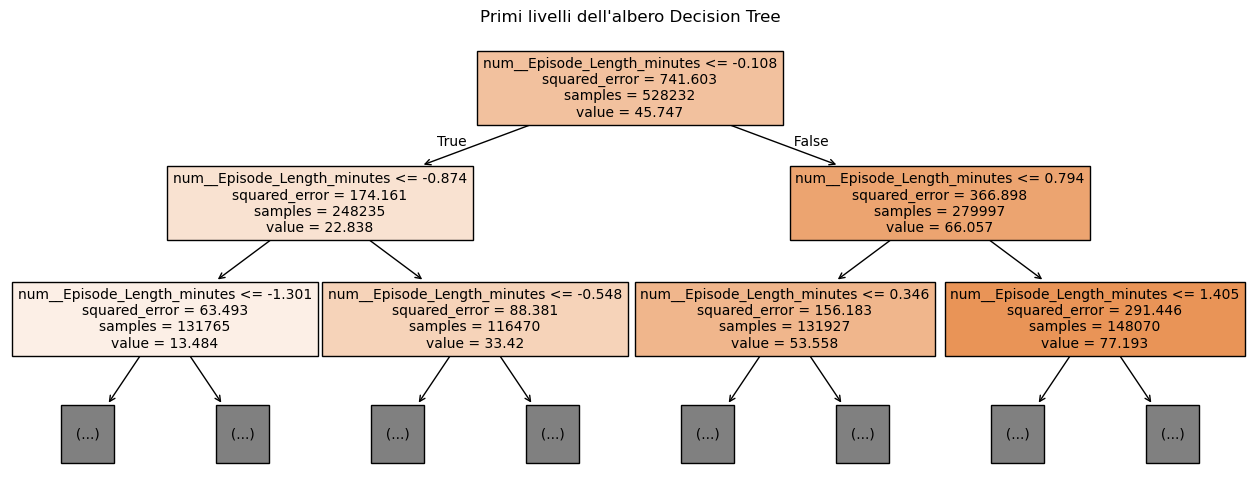

In [61]:
print("\nNODI DECISION TREE (primi livelli)")
tree_model = results['Decision Tree']['Model']
plt.figure(figsize=(16, 6))
plot_tree(tree_model, 
          feature_names=feature_names, 
          max_depth=2, 
          filled=True,
          fontsize=10)
plt.title("Primi livelli dell'albero Decision Tree")
plt.show()

Per i modelli random forest e XGBoost stampo i valori relativi alle feature importance


FEATURE IMPORTANCE - RANDOM FOREST
                                Feature  Importance
0           num__Episode_Length_minutes    0.980290
9                   num__Ads_per_minute    0.013142
1       num__Host_Popularity_percentage    0.003035
8                   num__Episode_Number    0.000610
2      num__Guest_Popularity_percentage    0.000588
16  num__Guest_Host_Combined_Popularity    0.000491
7        num__Episode_Sentiment_Numeric    0.000448
5          num__Publication_Day_Numeric    0.000246
71                cat__Genre_Technology    0.000100
6         num__Publication_Time_Numeric    0.000091


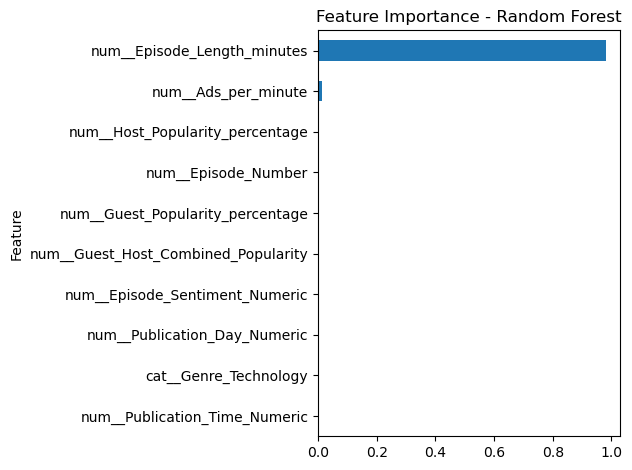


FEATURE IMPORTANCE - XGBOOST
                             Feature  Importance
0        num__Episode_Length_minutes    0.798148
12        num__Medium_Episode_Length    0.065502
9                num__Ads_per_minute    0.024101
14        num__Hight_Host_Popularity    0.006998
70                 cat__Genre_Sports    0.006856
56  cat__Podcast_Name_Study Sessions    0.005558
49   cat__Podcast_Name_Music Matters    0.004660
7     num__Episode_Sentiment_Numeric    0.004020
1    num__Host_Popularity_percentage    0.003994
71             cat__Genre_Technology    0.003345


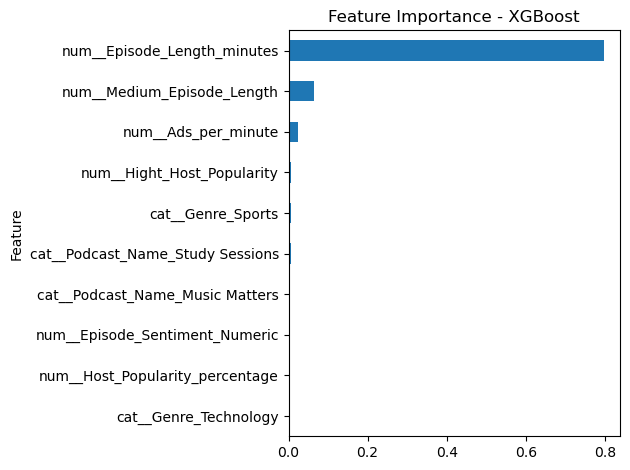

In [64]:
for name in ["Random Forest", "XGBoost"]:
    model = results[name]['Model']
    importances = model.feature_importances_
    imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    print(f"\nFEATURE IMPORTANCE - {name.upper()}")
    print(imp_df.head(10))

    imp_df.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
    plt.title(f'Feature Importance - {name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## Fase 5: Ricerca degli iperparametri
In questa fase cercheremo per 2 modelli gli iperparametri migliori cercando di migliorarne lo score, i due modelli sono ElasticNet e XGBoost, con elastic net proverò la grid search, mentre con xgboost proverò la randomized search

Librerie:
- sklearn
    - GridSearchCV: per effettuare la grid search, prova tutte le combinazioni possibili dei parametri passati
    - RandomizedSearchCV: per effettuare la randomized search, prova un numero fisso di combinazioni prese casualmente da quelle passate
    - KFold: tecnica di cross validation che permette di dividere il dataset in N parti uguali valutando il modello su ogni parte addestrandolo sulle altre 4
    - cross_val_score: utility per effettuare la nested cross validation

In [30]:
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, cross_val_score

Proviamo inoltre ad usare la nested CV per avere uno score ancora più accurato, la nested CV permette di stimare in modo più affidabile le prestazioni generalizzabili di un modello, evitando il rischio di overfitting durante la fase di selezione degli iperparametri, separando il processo di tuning da quello di valutazione.

In [43]:
elastic_params = {
    'regressor__alpha': [0.1, 1.0],
    'regressor__l1_ratio': [0.1, 0.5, 1.0]
}

elastic_pipe = Pipeline([
    ('preprocessing', linear_preprocessor),
    ('regressor', ElasticNet(random_state=42))
])

inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

elastic_grid = GridSearchCV(
    estimator=elastic_pipe,
    param_grid=elastic_params,
    cv=inner_cv,
    scoring="neg_root_mean_squared_error"
)

nested_scores = cross_val_score(elastic_grid, X=X_train, y=y_train, cv=outer_cv)
print("Accuratezza media stimata (nested CV con negative RMSE):", np.mean(nested_scores))


elastic_grid.fit(X_train, y_train)
y_pred = elastic_grid.predict(X_test)

print("Best ElasticNet params:", elastic_grid.best_params_)
print("Best ElasticNet score (R2):", r2_score(y_test, y_pred))
print("Best ElasticNet score (MSE):", mean_squared_error(y_test, y_pred))
print("Best ElasticNet score (RMSE):", root_mean_squared_error(y_test, y_pred))

Accuratezza media stimata (nested CV): -10.504101875498018
Best ElasticNet params: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 1.0}
Best ElasticNet score (R2): 0.8516049387104682
Best ElasticNet score (MSE): 110.18632307205287
Best ElasticNet score (RMSE): 10.496967327378554


In [31]:
xgb_param_dist = {
    "regressor__learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "regressor__max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "regressor__min_child_weight": [1, 3, 5, 7],
    "regressor__gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "regressor__colsample_bytree": [0.3, 0.4, 0.5, 0.7]
}


xgb_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', XGBRegressor(random_state=42, verbosity=0))
])

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_param_dist,
    n_iter=30,
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
)

xgb_random_search.fit(X_train, y_train)

y_pred = xgb_random_search.predict(X_test)

print("Best XGBRegressor params:", xgb_random_search.best_params_)
print("Best XGBRegressor score (R2):", r2_score(y_test, y_pred))
print("Best XGBRegressor score (MSE):", mean_squared_error(y_test, y_pred))
print("Best XGBRegressor score (RMSE):", root_mean_squared_error(y_test, y_pred))

Best XGBRegressor params: {'regressor__min_child_weight': 3, 'regressor__max_depth': 15, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0.3, 'regressor__colsample_bytree': 0.7}
Best XGBRegressor score (R2): 0.8624230667583717
Best XGBRegressor score (MSE): 102.15364501819619


NameError: name 'root_mean_squared_error' is not defined

Come ultimo step salvo i parametri di XGBoost su file in modo da poterli usare nel web server

In [ ]:
import joblib

joblib.dump(xgb_random_search.best_estimator_, 'xgb_best_pipeline.pkl')

Proviamo ora ad addestrare un modello MLP per compararlo con XGBoost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

X = df_train.drop(columns=["Listening_Time_minutes"])
y = df_train["Listening_Time_minutes"]

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

PolynomialFeatures()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = keras.Sequential([
    layers.Dense(128, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    verbose=1
)

y_pred = model.predict(X_test_scaled).flatten()
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"\nMSE: {mse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"RMSE Score: {rmse:.4f}")


Nel test di regressione, XGBoost ha ottenuto un RMSE leggermente migliore rispetto alla rete neurale Keras, mostrando prestazioni più solide sui dati. Questo indica che, con il dataset usato, XGBoost è stato più efficace nel modellare le relazioni tra le variabili.

## Conclusione
Tramite questo progetto si è riuscito a trovare un modello di regressione capace di predire il tempo di ascolto di un podcast dalle sue caratteristiche.
Dall'analisi condotta possiamo notare che la feature più influente è la durata stessa del podcast, ma che influisce abbastanza anche il numero di ADS riprodotte durante l'ascolto.
Possiamo notare inoltre che il tempo di ascolto è poco dipendente dalla popolarità del podcast o dell'ospite (anche se a livello di feature importance nei vari modelli rimane comunque dal terzo al sesto posto circa).
Tramite il feature engineering siamo riusciti a migliorare di molto il modello che, senza il lavoro eseguito sulle feature e sulla sanificazione del dataset, avrebbe preso uno score RMSE con XGBoost attorno al 13.
Abbiamo inoltre notato che la grid search e la randomized search hanno migliorato i modelli ottenendo prestazioni ancora migliori, in particolare ElasticNet ha migliorato il suo score RMSE di 2 punti.